In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
data_dir = "/content/gdrive/MyDrive/Batik Dataset Enhanched/Batik"

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=270,
                                   zoom_range=0.2,
                                   width_shift_range=0.15,
                                   height_shift_range=0.15,
                                   shear_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='wrap',
                                   validation_split=0.25)


In [5]:
train_generator = train_datagen.flow_from_directory(data_dir,
                                                    target_size=(224,224),
                                                    shuffle=True,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    subset='training')

validation_generator = train_datagen.flow_from_directory(data_dir,
                                                         target_size=(224, 224),
                                                         color_mode='rgb',
                                                         shuffle=False,
                                                         class_mode='categorical',
                                                         subset='validation')

Found 723 images belonging to 19 classes.
Found 228 images belonging to 19 classes.


In [6]:
from tensorflow.keras import layers
from tensorflow.keras import Model

base_model = tf.keras.applications.InceptionV3(
    include_top=False, weights='imagenet', pooling="max",
    classifier_activation=None
)

"""for layer in base_model.layers[:-1]:
    model.add(layer)  """  

# Freeze the layers 
for layer in base_model.layers:
    layer.trainable = False

x = layers.Flatten()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.3)(x)                  
x = layers.Dense  (19, activation='softmax')(x)           

model = Model(base_model.input, x)

model.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_____________________________

In [7]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["acc"])

In [8]:
"""from tensorflow.keras.callbacks import EarlyStopping

callbacks = EarlyStopping(monitor='val_acc')"""

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.9):
      print("\nReached 90% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

In [10]:
history = model.fit(train_generator, validation_data=validation_generator, epochs=500, steps_per_epoch=15, callbacks=[callbacks])

Epoch 1/500
15/15 [==============================] - 340s 21s/step - loss: 9.7080 - acc: 0.0875 - val_loss: 4.6811 - val_acc: 0.1579
Epoch 2/500
15/15 [==============================] - 68s 5s/step - loss: 3.2493 - acc: 0.1970 - val_loss: 2.5883 - val_acc: 0.2456
Epoch 3/500
15/15 [==============================] - 34s 2s/step - loss: 2.6158 - acc: 0.1991 - val_loss: 2.4632 - val_acc: 0.2632
Epoch 4/500
15/15 [==============================] - 21s 1s/step - loss: 2.4063 - acc: 0.2570 - val_loss: 2.3097 - val_acc: 0.2807
Epoch 5/500
15/15 [==============================] - 17s 1s/step - loss: 2.3189 - acc: 0.2833 - val_loss: 2.2254 - val_acc: 0.3202
Epoch 6/500
15/15 [==============================] - 16s 1s/step - loss: 2.1446 - acc: 0.3340 - val_loss: 2.1729 - val_acc: 0.3509
Epoch 7/500
15/15 [==============================] - 16s 1s/step - loss: 2.0542 - acc: 0.3562 - val_loss: 2.1475 - val_acc: 0.3465
Epoch 8/500
15/15 [==============================] - 15s 1s/step - loss: 2.0947 -

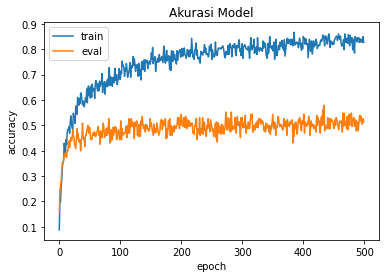

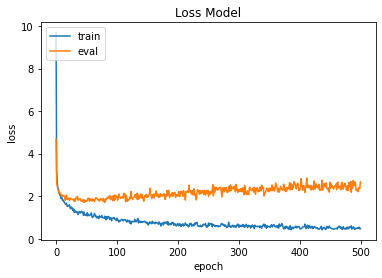

In [11]:
import matplotlib.pyplot as plt

# Accuracy plotting
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'eval'], loc='upper left')
plt.show()

# Loss plotting
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'eval'], loc='upper left')
plt.show()

In [12]:
tf.saved_model.save(model, "BatikClassificationV4-InceptionV3")


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: BatikClassificationV4-InceptionV3/assets


In [13]:
!zip -r /content/BatikClassificationV4-InceptionV3.zip /content/BatikClassificationV4-InceptionV3

  adding: content/BatikClassificationV4-InceptionV3/ (stored 0%)
  adding: content/BatikClassificationV4-InceptionV3/assets/ (stored 0%)
  adding: content/BatikClassificationV4-InceptionV3/saved_model.pb (deflated 93%)
  adding: content/BatikClassificationV4-InceptionV3/variables/ (stored 0%)
  adding: content/BatikClassificationV4-InceptionV3/variables/variables.data-00000-of-00001 (deflated 13%)
  adding: content/BatikClassificationV4-InceptionV3/variables/variables.index (deflated 79%)


In [14]:
label = []
import os
for dirname, _, filenames in os.walk(data_dir):
    for filename in filenames:
        label.append(os.path.join(dirname, filename).split('/')[-2])

labels = np.unique(label)
ints = np.arange(0, len(label))
dicts = dict(zip(labels, ints))
dicts

{'batik-betawi': 0,
 'batik-celup': 1,
 'batik-cendrawasih': 2,
 'batik-ceplok': 3,
 'batik-ciamis': 4,
 'batik-garutan': 5,
 'batik-gentongan': 6,
 'batik-kawung': 7,
 'batik-keraton': 8,
 'batik-lasem': 9,
 'batik-megamendung': 10,
 'batik-parang': 11,
 'batik-pekalongan': 12,
 'batik-priangan': 13,
 'batik-sekar-jagad': 14,
 'batik-sidoluhur': 15,
 'batik-sidomukti': 16,
 'batik-sogan': 17,
 'batik-tambal': 18}

In [15]:
y_true = validation_generator.classes

print(y_true)

[ 0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1
  2  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3
  4  4  4  4  4  4  4  4  4  4  4  4  5  5  5  5  5  5  5  5  5  5  5  5
  6  6  6  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9  9  9  9
 10 10 10 10 10 10 10 10 10 10 10 10 11 11 11 11 11 11 11 11 11 11 11 11
 12 12 12 12 12 12 12 12 12 12 12 12 13 13 13 13 13 13 13 13 13 13 13 13
 14 14 14 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15 15 15 15
 16 16 16 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 17 17 17
 18 18 18 18 18 18 18 18 18 18 18 18]


In [16]:
predictions = model.predict(validation_generator)
y_pred = np.rint(predictions)
y_pred = np.argmax(y_pred, axis=1)

print(y_pred)

[ 0  0  0  0  0  0  0  0  0  9  0  0  0  1  1  1  1  1  1  1  1  1  0  1
  0  2  0  2  2  8 16  9  2  2  0  6  7  0 14 15  0  9  3  3  3  3  0  3
 12 16  4  4  4 13  0 17  4  8  4  0  0  5  0  5  5  0 12  7  5  5  5  8
  0  6  0  5  6 16  0  0 13  0  4  6  7  7  7 16  7  7  7  7  7  7  7  7
  9 13 17 11  0  2  8  0  0  8  5  0  9  0 14  9  0  9  6  0  0 14  9 12
 10 10 10 10 10 10 10 10 10 10 10 10 11  8 11 11 11  5 11 10 11 11 11 11
  8 12  6  4 12 13 16  2  4  0 12  4  0  0 13 13  6  6 11  0 13 13  0  5
  0 14 14 15 14 15 14 14 15 14  0 14 15 14 15 15 15  6 15  0 15  0 16 15
 17 15 14 16  0  0 15 15 14 16 16 16 14  6 11  0 17  8 17  5  0 17  2 17
 18 11  0 18  5 18 18 15 18 18 18 18]


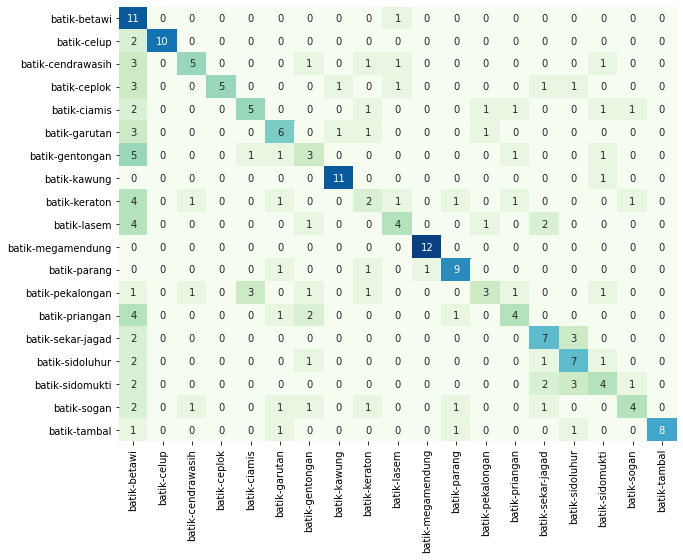

In [17]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, cmap='GnBu', cbar=False)
plt.xticks(ticks=np.arange(0.5, len(list(dicts.keys()))), labels = list(dicts.keys()), rotation=90)
plt.yticks(ticks=np.arange(0.5, len(list(dicts.keys()))), labels = list(dicts.keys()), rotation=0)
plt.show()

In [18]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.22      0.92      0.35        12
           1       1.00      0.83      0.91        12
           2       0.62      0.42      0.50        12
           3       1.00      0.42      0.59        12
           4       0.56      0.42      0.48        12
           5       0.50      0.50      0.50        12
           6       0.30      0.25      0.27        12
           7       0.85      0.92      0.88        12
           8       0.25      0.17      0.20        12
           9       0.50      0.33      0.40        12
          10       0.92      1.00      0.96        12
          11       0.69      0.75      0.72        12
          12       0.50      0.25      0.33        12
          13       0.50      0.33      0.40        12
          14       0.50      0.58      0.54        12
          15       0.47      0.58      0.52        12
          16       0.40      0.33      0.36        12
          17       0.57    